# Imports and Setup

In [4]:
%load_ext autoreload
%autoreload 1
%aimport prep
%config InlineBackend.figure_formats = ["jpg"]

import matplotlib.pyplot as plt 
plt.style.use(['science',"nature","notebook", "cjk-jp-font"])
plt.rcParams.update({
    "font.family": "serif",   # specify font family here
    "font.serif": ["Computer", "Noto Serif CJK jp"],  # specify font here
    "font.size":11,
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
    "figure.figsize": (5, 3),
    }
)          # specify font size here

plt.rcParams['figure.figsize'] = [5.0, 3.0]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 24

from prep import *
import pandas as pd
import statsmodels
from sklearn.metrics import mean_squared_error
from collections import namedtuple

In [5]:
import matplotlib.pyplot as plt


In [6]:
df = pd.read_csv("../data/suumo.csv", low_memory=False, index_col=0)
df["apt_style"] = df["apt_style"].apply(apt_style_clean)

df["log_apt_rent"] = np.log(df["apt_rent"])


# Taking light look at data

In [7]:
moststations = df.groupby("station").mean().sort_values(by="apt_rent", ascending=False)

In [8]:
ook="東急大井町線/大岡山駅"
onarimon='都営三田線/御成門駅'

# Regression

In [10]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

##  Fit regression model 

Also declare two helper functions

In [144]:
def linear_model(formula, df, targ,model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    preds = results.predict(df)
    targs = df[targ]
    if model_name is None:
        model_name = formula.format(targ)
    fig,annot = plot_regression_once(preds,targs,model_name)
    print(annot)
    fig.savefig("../../paper/assets/" + model_name + ".jpg")
    return results,fig

def set_base(ser, base):
    cats = list(ser.unique())
    idx = cats.index(base)
    cats[idx] = cats[0]
    cats[0] = base
    return pd.Categorical(ser, categories=cats)

In [145]:
df["station"] = set_base(df["station"], "ＪＲ山手線/浜松町駅")
df["apt_style"] = set_base(df["apt_style"], "ワンルーム")
df["method"] = set_base(df["method"], "歩")

In [146]:
df

,b_name,b_age,b_address,b_no_floors,apt_detail_link,apt_size,apt_rent,apt_style,apt_admin_price,apt_floor,apt_thanks_fee,apt_deposit,full_apt_detail_link,rel_image_paths,id,station,method,time_to_station,unit,log_apt_rent
0,スカイコート浜松町,18.0,東京都港区芝浦１,8.0,/chintai/jnc_000061132945/?bc=100263201569,20.16,7.70,1K,8000.0,5.0,7.70,7.7,https://suumo.jp//chintai/jnc_000061132945/?bc...,full/d94a4a36137325d06c8875af0f11e489848e3c1e.jpg,d94a4a36137325d06c8875af0f11e489848e3c1e,ＪＲ山手線/浜松町駅,歩,6,分,2.041220
1,スカイコート浜松町,18.0,東京都港区芝浦１,8.0,/chintai/jnc_000070609463/?bc=100263210743,20.16,7.70,1K,8000.0,6.0,7.70,7.7,https://suumo.jp//chintai/jnc_000070609463/?bc...,full/a2a59ac192e980871771950ad1c05b6cdbc1b040.jpg,a2a59ac192e980871771950ad1c05b6cdbc1b040,ＪＲ山手線/浜松町駅,歩,6,分,2.041220
2,スカイコート浜松町,18.0,東京都港区芝浦１,8.0,/chintai/jnc_000070526953/?bc=100262776795,20.44,8.07,1K,6800.0,1.0,8.07,0.0,https://suumo.jp//chintai/jnc_000070526953/?bc...,full/406bc02621a14f9badcf66e73f1fe9d363dba1f2.jpg,406bc02621a14f9badcf66e73f1fe9d363dba1f2,ＪＲ山手線/浜松町駅,歩,6,分,2.088153
3,スカイコート浜松町,18.0,東京都港区芝浦１,8.0,/chintai/jnc_000068981658/?bc=100243194498,20.16,8.22,1K,6800.0,3.0,8.22,0.0,https://suumo.jp//chintai/jnc_000068981658/?bc...,full/53780aaac6fb5d05a806e1259455485fe42ed428.jpg,53780aaac6fb5d05a806e1259455485fe42ed428,ＪＲ山手線/浜松町駅,歩,6,分,2.106570
4,スカイコート浜松町,18.0,東京都港区芝浦１,8.0,/chintai/jnc_000068805635/?bc=100244617149,20.16,8.95,1K,0.0,4.0,8.95,0.0,https://suumo.jp//chintai/jnc_000068805635/?bc...,full/63a09923f443d2be7f6973acf4c871a852bd1146.jpg,63a09923f443d2be7f6973acf4c871a852bd1146,ＪＲ山手線/浜松町駅,歩,6,分,2.191654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141389,ＸＥＢＥＣ蒲田,2.0,東京都大田区西蒲田８,13.0,/chintai/jnc_000066036326/?bc=100242715280,25.09,10.70,1K,10000.0,4.0,10.70,0.0,https://suumo.jp//chintai/jnc_000066036326/?bc...,full/4b1536d295154b207fa60811d221639b8a4bbb39.jpg,4b1536d295154b207fa60811d221639b8a4bbb39,ＪＲ京浜東北線/蒲田駅,歩,3,分,2.370244
141390,ＸＥＢＥＣ蒲田,2.0,東京都大田区西蒲田８,13.0,/chintai/jnc_000066036319/?bc=100242715305,25.09,11.00,1K,10000.0,11.0,11.00,0.0,https://suumo.jp//chintai/jnc_000066036319/?bc...,full/4a891f69a43f6f3dde8e5008e4c72937e7b67bef.jpg,4a891f69a43f6f3dde8e5008e4c72937e7b67bef,ＪＲ京浜東北線/蒲田駅,歩,3,分,2.397895
141391,大旭小村井ハイツ,2.0,東京都墨田区文花２,3.0,/chintai/jnc_000063710214/?bc=100222839495,15.98,6.20,ワンルーム,3000.0,1.0,0.00,0.0,https://suumo.jp//chintai/jnc_000063710214/?bc...,full/a9755e2bf2781bd4ec51c05652755e6ec903ba5a.jpg,a9755e2bf2781bd4ec51c05652755e6ec903ba5a,東武亀戸線/小村井駅,歩,1,分,1.824549
141392,東京メトロ有楽町線 要町駅 地下1地上5階建 築2年,2.0,東京都豊島区要町１,5.0,/chintai/jnc_000069954314/?bc=100259475075,27.30,9.50,1K,10000.0,1.0,0.00,9.5,https://suumo.jp//chintai/jnc_000069954314/?bc...,full/984b8868b5dc06e1caa439b3009beade0ef6b1e0.jpg,984b8868b5dc06e1caa439b3009beade0ef6b1e0,東京メトロ有楽町線/要町駅,歩,1,分,2.251292


### Simple Regression of easiest variables on `rent`

       Correlation    MSE            RMSE           N    
---------------------------------------------------------
Train  0.860          17.65          4.20           141394 


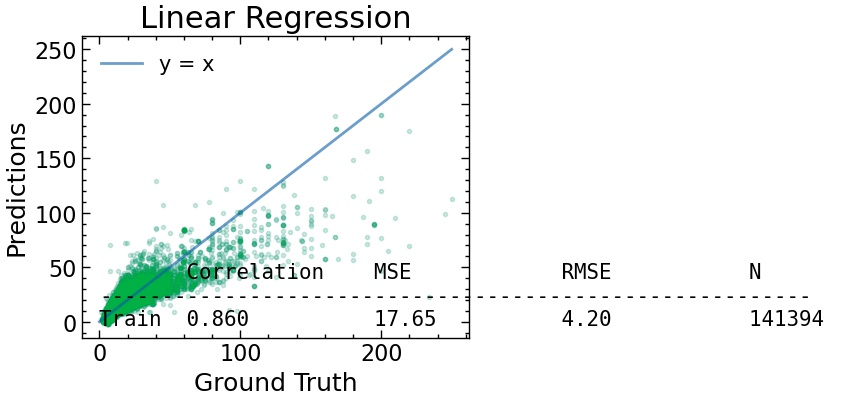

In [150]:
res,p = linear_model("{} ~"
                        "+ b_no_floors " 
                        "+ apt_size"
                        # "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        # "+ station"
                        ,df, "apt_rent", model_name="Linear Regression")
# res.summary()

       Correlation    MSE            RMSE           N    
---------------------------------------------------------
Train  0.858          0.05           0.22           141394 


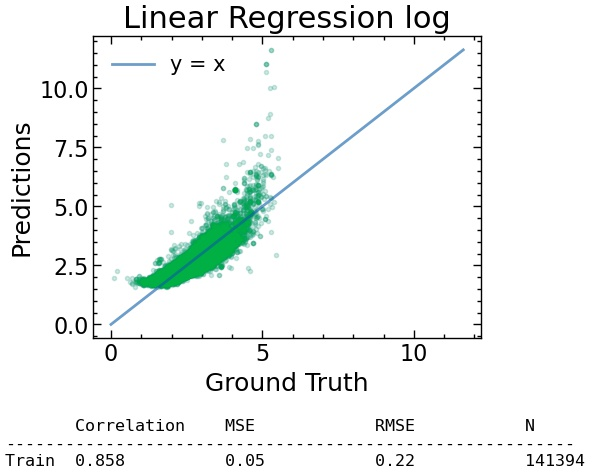

In [159]:
res,p = linear_model("{} ~"
                        "+ b_no_floors " 
                        "+ apt_size"
                        # "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        # "+ station"
                        ,df, "log_apt_rent", model_name="Linear Regression log")
# res.summary()
            

### Regression on rent with `apt_style`

       Correlation    MSE            RMSE           N    
---------------------------------------------------------
Train  0.877          15.68          3.96           141394 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               apt_rent   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Sun, 26 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:16:43   Log-Likelihood:            -3.9520e+05
No. Observations:              141394   AIC:                         7.905e+05
Df Residuals:                  141354   BIC:                         7.909e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.6884      0.042    -64.609      0.000      -2.770      -2.607
apt_style[T.1K]                 -0.8589      0.029    -29.869      0.000      -0.915      -0.803
apt_style[T.2DK]                -6.6653      0.064   -104.309      0.000      -6.791      -6.540
apt_style[T.2LDK]               -4.2044      0.073    -57.617      0.000      -4.347      -4.061
apt_style[T.5以上]               -25.9629      0.398    -65.211      0.000     -26.743     -25.183
apt_style[T.1SLDK]              -5.2744      0.171    -30.862      0.000      -5.609      -4.939
apt_style[T.1LDK]               -2.7213      0.045    -60.461      0.000      -2.810      -2.633
apt_style[T.2SLDK]              -5.5027      0.225    -24.411      0.000      -5.945      -5.061
apt_style[T.3LDK]               -7.0819      0.120    -59.151      0.000      -7.317      -6.847
apt_style[T.1DK]                -1.9975      0.045    -44.092      0.000      -2.086      -1.909
apt_style[T.2K]                 -4.0492      0.075    -54.055      0.000      -4.196      -3.902
apt_style[T.3DK]               -11.3838      0.163    -70.031      0.000     -11.702     -11.065
apt_style[T.4LDK]              -13.1740      0.284    -46.307      0.000     -13.732     -12.616
apt_style[T.3K]                 -8.9046      0.325    -27.399      0.000      -9.542      -8.268
apt_style[T.1SK]                -2.0076      0.298     -6.736      0.000      -2.592      -1.423
apt_style[T.4K]                -13.6519      0.713    -19.134      0.000     -15.050     -12.254
apt_style[T.3SDK]               -7.7719      0.866     -8.973      0.000      -9.470      -6.074
apt_style[T.2SDK]               -9.8939      0.532    -18.607      0.000     -10.936      -8.852
apt_style[T.4DK]               -13.5563      0.638    -21.244      0.000     -14.807     -12.306
apt_style[T.4SLDK]             -10.1657      0.576    -17.640      0.000     -11.295      -9.036
apt_style[T.3LK]                -9.5818      3.960     -2.419      0.016     -17.344      -1.820
apt_style[T.1SDK]               -3.4269      0.377     -9.081      0.000      -4.167      -2.687
apt_style[T.3SLDK]              -6.4675      0.362    -17.878      0.000      -7.177      -5.758
apt_style[T.2SK]                -5.9290      1.059     -5.599      0.000      -8.004      -3.854
apt_style[T.1SLK]               -7.2618      2.801     -2.593      0.010     -12.751      -1.772
apt_style[T.3SK]               -15.0177      1.772     -8.474      0.000     -18.491     -11.544
apt_style[T.4SDK]              -28.5076      1.983    -14.374      0.000     -32.395     -24.620
apt_style[T.1LK]                -2.6017      0.990     -2.627      0.009      -4.543      -0.660
apt_style[T.2LK]                -4.8560      3.960     -1.226      0.220    

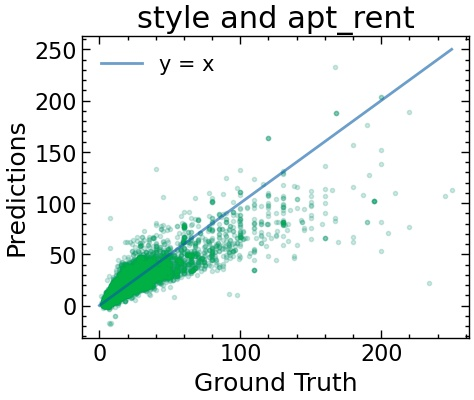

In [131]:
res,p = linear_model("{} ~ b_no_floors " 
                         "+ apt_size"
                        "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        # "+ station"
                        ,df, "apt_rent",
                    model_name="style and apt_rent")
res.summary()

### Regression on log rent with style

       Correlation    MSE            RMSE           N    
---------------------------------------------------------
Train  0.885          0.04           0.20           141394 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_apt_rent   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 1.315e+04
Date:                Sun, 26 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:04:49   Log-Likelihood:                 25883.
No. Observations:              141394   AIC:                        -5.169e+04
Df Residuals:                  141354   BIC:                        -5.129e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.5841      0.002    748.070      0.000       1.580       1.588
apt_style[T.1K]                  0.0259      0.001     17.684      0.000       0.023       0.029
apt_style[T.2DK]                -0.0044      0.003     -1.350      0.177      -0.011       0.002
apt_style[T.2LDK]                0.2276      0.004     61.297      0.000       0.220       0.235
apt_style[T.5以上]                -1.1178      0.020    -55.170      0.000      -1.158      -1.078
apt_style[T.1SLDK]               0.1960      0.009     22.536      0.000       0.179       0.213
apt_style[T.1LDK]                0.2526      0.002    110.295      0.000       0.248       0.257
apt_style[T.2SLDK]               0.1430      0.011     12.464      0.000       0.120       0.165
apt_style[T.3LDK]                0.0803      0.006     13.181      0.000       0.068       0.092
apt_style[T.1DK]                 0.0929      0.002     40.303      0.000       0.088       0.097
apt_style[T.2K]                 -0.0278      0.004     -7.281      0.000      -0.035      -0.020
apt_style[T.3DK]                -0.0671      0.008     -8.107      0.000      -0.083      -0.051
apt_style[T.4LDK]               -0.4364      0.014    -30.144      0.000      -0.465      -0.408
apt_style[T.3K]                 -0.0318      0.017     -1.923      0.055      -0.064       0.001
apt_style[T.1SK]                 0.1010      0.015      6.662      0.000       0.071       0.131
apt_style[T.4K]                 -0.1182      0.036     -3.255      0.001      -0.189      -0.047
apt_style[T.3SDK]                0.1336      0.044      3.031      0.002       0.047       0.220
apt_style[T.2SDK]                0.0817      0.027      3.020      0.003       0.029       0.135
apt_style[T.4DK]                -0.0175      0.032     -0.540      0.589      -0.081       0.046
apt_style[T.4SLDK]              -0.6052      0.029    -20.636      0.000      -0.663      -0.548
apt_style[T.3LK]                 0.0812      0.202      0.403      0.687      -0.314       0.476
apt_style[T.1SDK]                0.2009      0.019     10.461      0.000       0.163       0.239
apt_style[T.3SLDK]              -0.0476      0.018     -2.583      0.010      -0.084      -0.011
apt_style[T.2SK]                 0.0207      0.054      0.384      0.701      -0.085       0.126
apt_style[T.1SLK]               -0.0005      0.143     -0.004      0.997      -0.280       0.279
apt_style[T.3SK]                -0.0807      0.090     -0.895      0.371      -0.257       0.096
apt_style[T.4SDK]               -0.4135      0.101     -4.097      0.000      -0.611      -0.216
apt_style[T.1LK]                 0.1935      0.050      3.840      0.000       0.095       0.292
apt_style[T.2LK]                 0.2508      0.202      1.244      0.213    

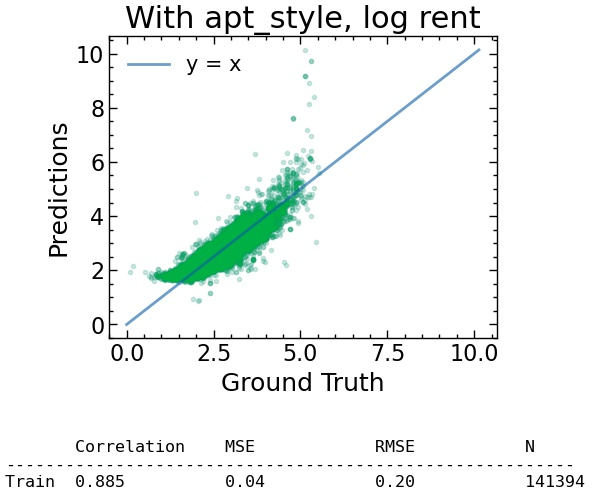

In [160]:
res,p = linear_model("{} ~ b_no_floors " 
                         "+ apt_size"
                        "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        # "+ station"
                        ,df, "log_apt_rent",
                     model_name="With apt_style, log rent"
                    )
res.summary()

### Regression on apt_rent using all variables

       Correlation    MSE            RMSE           N    
---------------------------------------------------------
Train  0.900          12.83          3.58           141394 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               apt_rent   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     834.5
Date:                Sun, 26 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:31:20   Log-Likelihood:            -3.8102e+05
No. Observations:              141394   AIC:                         7.635e+05
Df Residuals:                  140671   BIC:                         7.706e+05
Df Model:                         722                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.5910      0.299     -5.320      0.000      -2.177      -1.005
apt_style[T.1K]                      -0.4530      0.027    -17.049      0.000      -0.505      -0.401
apt_style[T.2DK]                     -5.2304      0.059    -88.368      0.000      -5.346      -5.114
apt_style[T.2LDK]                    -3.2548      0.067    -48.442      0.000      -3.387      -3.123
apt_style[T.5以上]                    -20.9566      0.365    -57.478      0.000     -21.671     -20.242
apt_style[T.1SLDK]                   -3.9592      0.156    -25.314      0.000      -4.266      -3.653
apt_style[T.1LDK]                    -2.2410      0.042    -53.997      0.000      -2.322      -2.160
apt_style[T.2SLDK]                   -3.8399      0.206    -18.675      0.000      -4.243      -3.437
apt_style[T.3LDK]                    -5.0736      0.110    -45.930      0.000      -5.290      -4.857
apt_style[T.1DK]                     -1.4629      0.042    -34.960      0.000      -1.545      -1.381
apt_style[T.2K]                      -3.0465      0.069    -44.199      0.000      -3.182      -2.911
apt_style[T.3DK]                     -9.2060      0.150    -61.391      0.000      -9.500      -8.912
apt_style[T.4LDK]                    -9.5465      0.261    -36.614      0.000     -10.058      -9.035
apt_style[T.3K]                      -7.3042      0.296    -24.663      0.000      -7.885      -6.724
apt_style[T.1SK]                     -1.6812      0.276     -6.100      0.000      -2.221      -1.141
apt_style[T.4K]                     -11.4185      0.649    -17.585      0.000     -12.691     -10.146
apt_style[T.3SDK]                    -6.4850      0.788     -8.227      0.000      -8.030      -4.940
apt_style[T.2SDK]                    -8.0204      0.484    -16.582      0.000      -8.968      -7.072
apt_style[T.4DK]                    -12.0900      0.580    -20.831      0.000     -13.228     -10.952
apt_style[T.4SLDK]                   -6.0066      0.525    -11.440      0.000      -7.036      -4.978
apt_style[T.3LK]                     -7.7526      3.597     -2.155      0.031     -14.802      -0.703
apt_style[T.1SDK]                    -2.7320      0.344     -7.949      0.000      -3.406      -2.058
apt_style[T.3SLDK]                   -4.2716      0.331    -12.900      0.000      -4.921      -3.623
apt_style[T.2SK]                     -5.5661      0.961     -5.791      0.000      -7.450      -3.682
apt_style[T.1SLK]                    -5.3210      2.546     -2.090      0.037     -10.310      -0.332
apt_style[T.3SK]                    -12.7679      1.613     -7.917      0.000     -15.929      -9.607
apt_style[T.4SDK]                   -24.7287      1.802    -13.722      0.000     -28.261     -21.197
apt_style[T.1LK]       

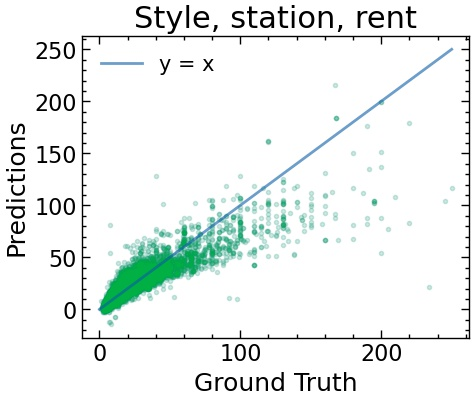

In [132]:
m3,p = linear_model("{} ~ b_no_floors " 
                         "+ apt_size"
                        "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        "+ station"
                        ,df, "apt_rent",
                    model_name="Style, station, rent")
m3.summary()

### Regerssion on all variables using `log_rent`

       Correlation    MSE            RMSE           N    
---------------------------------------------------------
Train  0.926          0.03           0.16           141394 


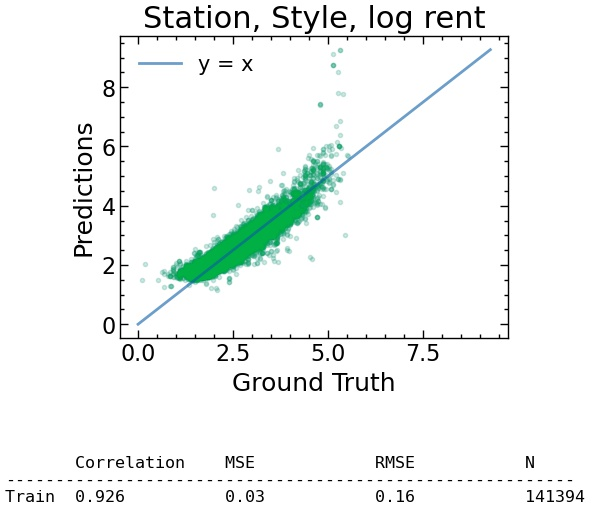

In [191]:
m4,p = linear_model("{} ~ b_no_floors " 
                         "+ apt_size"
                        "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        "+ method * np.sqrt(time_to_station)"
                        "+ station"
                        ,df, "log_apt_rent",
                    model_name="Station, Style, log rent")

We can see that it is mostly overvaluing the most places

In [131]:

from statsmodels.iolib.summary2 import summary_col


In [132]:
summary_col([m3, m4])

,apt_rent,log_apt_rent
Intercept,-1.5910,1.7030
,(0.2991),(0.0137)
apt_style[T.1K],-0.4530,0.0513
,(0.0266),(0.0012)
apt_style[T.2DK],-5.2304,0.0971
,(0.0592),(0.0027)
apt_style[T.2LDK],-3.2548,0.2879
,(0.0672),(0.0031)
apt_style[T.5以上],-20.9566,-0.7986
,(0.3646),(0.0167)


In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [208]:
df.groupby("station").count()["b_name"].sort_values().iloc[-50:]

station
東急目黒線/不動前駅          753
ＪＲ京浜東北線/大井町駅        754
都営三田線/板橋区役所前駅       755
東京メトロ有楽町線/要町駅       756
東武東上線/大山駅           771
東京メトロ日比谷線/広尾駅       798
東急田園都市線/三軒茶屋駅       802
東急目黒線/武蔵小山駅         828
都営浅草線/馬込駅           850
東京メトロ南北線/白金高輪駅      851
都営三田線/西巣鴨駅          868
京急本線/平和島駅           874
東急池上線/蓮沼駅           882
東京メトロ東西線/早稲田駅       895
京急空港線/糀谷駅           896
東急池上線/池上駅           916
京王新線/初台駅            918
京王新線/幡ヶ谷駅           932
東京メトロ東西線/南砂町駅       933
ＪＲ総武線/平井駅           939
東急東横線/都立大学駅         953
ＪＲ総武線/錦糸町駅          975
東急東横線/祐天寺駅          976
東京メトロ東西線/門前仲町駅      989
東京メトロ東西線/木場駅        996
ＪＲ山手線/恵比寿駅         1000
東急田園都市線/池尻大橋駅      1011
東京メトロ東西線/西葛西駅      1012
東京メトロ半蔵門線/押上駅      1014
ＪＲ総武線/亀戸駅          1044
東京メトロ南北線/麻布十番駅     1057
都営大江戸線/西新宿五丁目駅     1059
ＪＲ山手線/目黒駅          1080
都営浅草線/西馬込駅         1094
ＪＲ山手線/池袋駅          1095
都営浅草線/本所吾妻橋駅       1096
ＪＲ山手線/駒込駅          1101
東京メトロ日比谷線/三ノ輪駅     1109
東京メトロ日比谷線/入谷駅      1115
都営大江戸線/両国駅         1128
京急本線/大森町駅          1137
東急東横線/学芸

In [210]:
df.groupby("station").count()["b_name"].sort_values().iloc[:50]

station
京急バス/西六郷三丁目           1
亀29/葛西南高              1
都営バス/白金六丁目            1
東京メトロ銀座線/新橋駅          1
亀29/西葛西六              1
東急バス/安詳寺前             1
都営バス/福島橋南詰            1
上58/大塚三               1
西葛26/南葛西住宅            1
ＪＲ中央線/東京駅             1
自01/東深沢小学校            1
ＪＲ京葉線/舞浜駅             1
東急バス/大田文化の森           1
都営バス/亀高橋              1
東急バス/池上橋              1
東京メトロ東西線/南行徳駅         1
黒06/五本木一              1
西武新宿線/新井薬師前駅          1
黒01・黒02/目黒消防署         1
東急バス/駒場               1
都営バス/中葛西五丁目           1
東急バス：黒01／02系/元競馬場前    1
東急バス/雪谷文化センター         1
都営バス/堺川               1
都営バス/東砂４丁目            1
ＪＲ中央線/新宿駅             1
京成押上線/四ツ木駅            1
都営バス　田87/北里研究所前       1
渋谷行き/バス               1
田87/北里研究所             1
S01/パークハイアット東京前       1
京急バス/弁天神社             1
東京メトロ丸ノ内線/新高円寺駅       1
都営バス/東陽一丁目            1
多摩01/都立大学駅南口          1
ＪＲ常磐線/金町駅             1
都営バス/新田住宅             1
多摩01/都立大学駅北口          1
都営バス/雷上組              1
東急・都営バス/目黒消防署         1
葛西22/雷上組              1
京急大師線/鈴木

In [192]:
cols = ["b_age",
        "b_no_floors",
        "apt_size" ,
        "apt_style",
        "apt_admin_price",
        "apt_floor",
        "method",
        "time_to_station"
       ]
targs = "log_apt_rent"
dm = pd.get_dummies(df[cols],drop_first=True)
rf = RandomForestRegressor(n_estimators=100,max_samples=10000,oob_score=True,)

In [193]:
tr_X, te_X, tr_y, te_y  = train_test_split(dm, df[targs], random_state=42)

In [194]:
rf.fit(tr_X, tr_y)

/Users/jiyanschneider/miniconda3/envs/ml4t/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RandomForestRegressor(max_samples=10000, oob_score=True)

In [195]:
train_preds = rf.predict(tr_X)
test_preds = rf.predict(te_X)

In [196]:
rf.oob_score_

0.9026760560130155

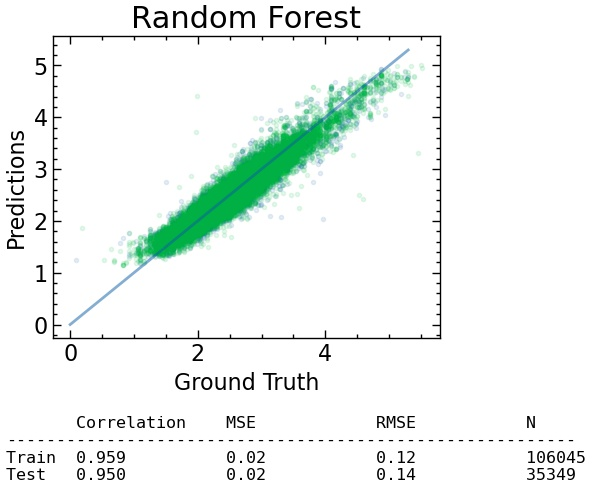

In [197]:
fig, annot = plot_regression(train_preds, tr_y, test_preds, te_y, "Random Forest")

In [198]:
print(annot)

       Correlation    MSE            RMSE           N    
---------------------------------------------------------
Train  0.959          0.02           0.12           106045 
Test   0.950          0.02           0.14           35349 


In [130]:
fig.savefig("../../paper/assets/Random Forest.jpg")

In [139]:
((df["log_apt_rent"] - df["log_apt_rent"].mean())**2).mean()

0.1879369913573636